## Set up Google Colab environment

In [0]:
### Set colaboratory True to run in Google Colaboratory. 
colab = True

if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    import os
    ## Specify a directory in Google Drive
    dir = '/content/drive/My Drive/Colab Notebooks/Keras_MNIST'
    os.chdir(dir)
    #os.getcwd()
    #os.listdir()

    ## Check the uptime. (Google Colab reboots every 12 hours)
    !cat /proc/uptime | awk '{print "Uptime is " $1 /60 /60 " hours (" $1 " sec)"}'
    ## Check the GPU info
    !nvidia-smi
    ## Check the Python version
    !python --version

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
Uptime is 0.0714528 hours (257.23 sec)
Wed Jan 30 08:36:12 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Comput

## Import modules

In [0]:
import os
import numpy as np
import pandas as pd
import time

import tensorflow as tf
from tensorflow import keras

tf.__version__

'1.12.0'

## Set up resumable logging feature

In [0]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

class LogFileProcessing():
    def __init__(self, resume_if_possible = True, log_file_path = 'training_log.csv', verbose = 1):
        self.log_file_path = log_file_path
        self.verbose = verbose
        self.update()
        if not resume_if_possible:
            self.clean_up()
            self.update()
    def update(self):
        log_file_path = self.log_file_path
        log_file_list = glob.glob(log_file_path)
        log_file_list.sort()
        self.log_file_list = log_file_list
        if self.verbose >= 2:
            print('Log file:', log_file_list)
        log_file_exists = len(log_file_list) >= 1
        self.log_file_exists = log_file_exists
    def truncate(self, epoch_from_model_file):
        log_file_path = self.log_file_path
        self.update()
        ## Remove rows after the epoch of the latest saved model 
        ## (needed because save_best_only option of checkpoint is set to True.)
        epoch_from_log_file = int(self.get_column_value('epoch'))
        epoch_diff = epoch_from_log_file - epoch_from_model_file 
        with open(log_file_path, 'r') as f:
            lines = f.readlines()
        if self.verbose >= 3:
            print('Log file contents read:', lines)
        lines_truncated = lines[:-(epoch_diff + 1)]
        with open(log_file_path, 'w') as f:
            f.writelines(lines_truncated)
        if self.verbose >= 3:
            print('New log file contents', lines_truncated)
    def clean_up(self):
        self.update()
        if self.log_file_exists:
            for f in self.log_file_list:
                os.remove(f)
            self.update()
    def get_df(self, dtype=None):
        self.update()
        if self.log_file_exists:
            try:
                return pd.read_csv(self.log_file_path, dtype=dtype)
            except:
                pass
        if self.verbose >= 2:
            print('Log file was not read as a DataFrame.')
        return None
    def get_column_value(self, column, default = '0'):
        log_df = self.get_df(dtype=str)
        if log_df is not None:
            if log_df.shape[0] >= 1:
                column_value = log_df.iloc[-1][column]
                return column_value
        if self.verbose >= 2:
            print('{} assumed to be {}.'.format(column, default))
        column_value = default
        return column_value    
    def plot_log(self, show_table = True):
        log_all_df = self.get_df()
        if log_all_df is not None:
            model_id_list = log_all_df['_Model_id'].unique()
            print('Model id list: ', model_id_list)
            for model_id in model_id_list: 
                print('### Model id: ', model_id)
                log_df = log_all_df.query('_Model_id == "{}"'.format(model_id))
                if show_table:
                    display(log_df)
                log_df.set_index('epoch')[['acc', 'val_acc']].plot(style='.-', title='Accuracy vs Epoch')
                plt.show()
                log_df.set_index('epoch')[['loss', 'val_loss']].plot(style='.-', title='Loss vs Epoch')
                plt.show()
                log_df.set_index('epoch')[['Comp_time', 'Cum_comp_time']].plot(style='.-', title='Computation Time (sec) vs Epoch')
                plt.show()          
            
class ModelFileProcessing():
    def __init__(self, model_id = '', model_file_prefix = 'model', model_file_suffix = '.hdf5', verbose = 1):
        model_file_prefix = model_file_prefix + model_id + '_epoch'
        self.model_file_prefix = model_file_prefix
        self.model_file_suffix = model_file_suffix
        self.verbose = verbose
        model_file_path = model_file_prefix + '{epoch:06d}' + model_file_suffix
        self.model_file_path = model_file_path
        self.update()
    def update(self):
        model_file_prefix = self.model_file_prefix
        model_file_suffix = self.model_file_suffix
        model_file_list = glob.glob(model_file_prefix + '*' + model_file_suffix)
        model_file_list.sort()
        if self.verbose >= 2:
            print('Model files: ', model_file_list)
        self.model_file_list = model_file_list
        model_file_exists = len(model_file_list) >= 1
        self.model_file_exists = model_file_exists

        latest_model_file = model_file_list[-1] if model_file_exists else None
        self.latest_model_file = latest_model_file

        latest_epoch = int(latest_model_file[len(model_file_prefix):-len(model_file_suffix)]) \
            if model_file_exists else 0
        self.latest_epoch = latest_epoch

        multiple_model_files_exist = len(model_file_list) >= 2
        self.multiple_model_files_exist = multiple_model_files_exist
    def clean_up_old(self):
        self.update()
        ## Delete all model files excpet the latest to save space
        if self.multiple_model_files_exist:
            for f in self.model_file_list[:-1]:
                os.remove(f)  
    def clean_up_all(self):
        self.update()
        ## Delete all model files if they exist.
        if self.model_file_exists:
            for f in self.model_file_list:
                os.remove(f)   
                
class ModelParams(keras.callbacks.Callback):
    def __init__(self, model_param_dict = {}, verbose = 2):
        self.model_param_dict = model_param_dict
        self.verbose = verbose
    def on_epoch_end(self, epoch, logs={}):
        if self.verbose >= 3:
            print('Model params: ', self.model_param_dict)
        ## Add the model parameters to the logs
        logs.update(self.model_param_dict)
        if self.verbose >= 3:
            print('logs: ', logs)
        
class OldModelFileCleanup(keras.callbacks.Callback):
    def __init__(self, mfp):
        self.mfp = mfp
    def on_epoch_end(self, epoch, logs={}):     
        self.mfp.clean_up_old()
        
import time          
class CompTime(keras.callbacks.Callback):
    def __init__(self, lfp):
        self.lfp = lfp
        self.verbose = lfp.verbose
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()
    def on_epoch_end(self, epoch, logs={}):
        ## Calculate computation time for the epoch
        comp_time = time.time() - self.epoch_time_start
        logs['Comp_time'] = comp_time
        if self.verbose >= 2:
            print('Computation time: {} sec'.format(comp_time))
        ## Calculate cumulative computation time up to the epoch
        cum_comp_time_past = \
        float(self.lfp.get_column_value('Cum_comp_time')) if epoch >= 1 else 0
        logs['Cum_comp_time'] = cum_comp_time_past + comp_time
          
def setup_model_and_callbacks(lfp, create_model, input_shape, resume_if_possible = True,
                             model_param_dict = {}, verbose = 1, early_stopping_patience = 5):
    
    mfp = ModelFileProcessing(model_id = model_param_dict['_Model_id'], verbose = 1)
    resume_flag = resume_if_possible and mfp.model_file_exists and lfp.log_file_exists ## To Do: if the model Id entry exists in the CSV log file.

    if resume_flag:
        ## Load the saved model
        model = keras.models.load_model(mfp.latest_model_file)
        print('Use {} to resume fitting.'.format(mfp.latest_model_file))
        initial_epoch = mfp.latest_epoch
        ## Truncate the log file
        lfp.truncate(epoch_from_model_file = mfp.latest_epoch) 

    if not resume_flag:
        ## Create a basic model instance
        model = create_model(input_shape)
        print('Model created.')
        initial_epoch = 0
        ## Delete all model files if they exist.
        mfp.clean_up_all()

    ## Create checkpoint callback
    check_point_ = tf.keras.callbacks.ModelCheckpoint(filepath = mfp.model_file_path, 
        monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'auto', 
        save_weights_only = False, period = 1)
    
    ## Create old model file cleanup callback
    old_model_file_cleanup_ = OldModelFileCleanup(mfp)
    
    ## Create computation time callback
    comp_time_ = CompTime(lfp)
    
    ## Create model params callback
    model_params_ = ModelParams(model_param_dict)

    ## Create CSV logger callback
    csv_logger_ = tf.keras.callbacks.CSVLogger(filename = lfp.log_file_path, separator=',',
                                               append = True)

    ## Create early stopping callback
    early_stopping_ = tf.keras.callbacks.EarlyStopping(monitor='val_acc', 
        min_delta=0, patience=early_stopping_patience, verbose=1, mode='auto', baseline=None)

    callbacks = [check_point_, old_model_file_cleanup_, 
                 model_params_, comp_time_, csv_logger_, early_stopping_]

    return model, callbacks, initial_epoch

## Set up dataset

In [0]:
dataset_name = 'MNIST'
#dataset_name = 'MNIST_1000samples'

if dataset_name in ['MNIST', 'MNIST_1000samples']:
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    print('x_train: ', x_train.shape)
    print('y_train', y_train.shape)
    print('x_test: ', x_test.shape)
    print('y_test', y_test.shape)

    input_shape = x_train.shape[1:]
    print('input_shape: ', input_shape )

    num_classes = 10

    x_train = x_train / 255.0
    x_test = x_test / 255.0
    
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

if dataset_name == 'MNIST_1000samples':
    ## Reduce samples size to speed up 
    n = 1000
    y_train = y_train[:n]
    y_test = y_test[:n]
    x_train = x_train[:n]
    x_test = x_test[:n]
    
print('\n### data after processing')
print('x_train: ', x_train.shape)
print('y_train', y_train.shape)
print('x_test: ', x_test.shape)
print('y_test', y_test.shape)

input_shape = x_train.shape[1:]
print('input_shape: ', input_shape )

11493376/11490434 [==============================] - 0s 0us/step
x_train:  (60000, 28, 28)
y_train (60000,)
x_test:  (10000, 28, 28)
y_test (10000,)
input_shape:  (28, 28)

### data after processing
x_train:  (60000, 28, 28, 1)
y_train (60000,)
x_test:  (10000, 28, 28, 1)
y_test (10000,)
input_shape:  (28, 28, 1)


## Set up model parameters

In [0]:
NotUsed="""
### Grid Search 
 
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.optimizers import SGD, Adagrad, RMSprop, Adam

batch_size_list = [64]

optimizer_dict = {}
#optimizer_dict['SGD'] = SGD()
#optimizer_dict['SGD_momentum_0.5'] = SGD(momentum = 0.5)
#optimizer_dict['SGD_momentum_0.9'] = SGD(momentum = 0.9)
#optimizer_dict['SGD_momentum_0.99'] = SGD(momentum = 0.99)         
#optimizer_dict['Adagrad'] = Adagrad()
#optimizer_dict['RMSprop'] = RMSprop()
optimizer_dict['Adam'] = Adam()

activation_list = []
activation_list.append('relu')
#activation_list.append('sigmoid')
#activation_list.append('elu')

objective_list = []
objective_list.append('sparse_categorical_crossentropy')
#objective_list.append('categorical_crossentropy')

dropout_rate_list = [0.0, 0.5]

model_param_dict_list = []
i = 0
for batch_size in batch_size_list:
    for optimizer, _ in optimizer_dict.items():
        for activation in activation_list:
            for objective in objective_list:
                for dropout_rate in dropout_rate_list:
                    d = {}
                    d['_Dataset_name'] = dataset_name
                    d['_Model_setup'] = 'Dense_Only'
                    d['_Model_id'] = '{:06d}'.format(i)
                    d['Batch_size'] = batch_size
                    d['Optimizer'] = optimizer
                    d['Acivation'] = activation
                    d['Objective'] = objective
                    d['Dropout_rate'] = dropout_rate
                    i += 1
                    print(d)
                    model_param_dict_list.append(d)
"""

In [0]:
### Create model_param_dict_list (derivative style)

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, Conv2D
from keras.optimizers import SGD, Adagrad, RMSprop, Adam, Adadelta, Adamax, Nadam

optimizer_dict = {\
'SGD': SGD(),
'SGD_momentum_0.5': SGD(momentum = 0.5),
'SGD_momentum_0.9': SGD(momentum = 0.9),
'SGD_momentum_0.99': SGD(momentum = 0.99),
'SGD_nesterov_momentum_0.9': SGD(momentum = 0.9, nesterov=True),
'SGD_nesterov_momentum_0.9_decay_1e-6': SGD(momentum = 0.9, decay=1e-6, nesterov=True),
'Adagrad': Adagrad(),
'RMSprop': RMSprop(),
'Adadelta': Adadelta(),
'Adamax': Adamax(),
'Adadelta': Adadelta(),
'Nadam': Nadam(),
'Adam': Adam(lr=0.001),
'Adam_lr0.0001': Adam(lr=0.0001),
'Adam_lr0.01': Adam(lr=0.01),
'Adam_lr0.1': Adam(lr=0.1)}

base_model_param_dict = \
{'_Dataset_name': dataset_name, '_Model_setup': 'CNN', '_Model_id': '000000', 
 'Batch_size': 64, 'Optimizer': 'Adam', 'Acivation': 'relu', 
 'Objective': 'sparse_categorical_crossentropy', 'Dropout_rate': 0.0}
derivative_dict_list = [\
 {'Dropout_rate': 0.3},
 {'Dropout_rate': 0.5},
 {'Dropout_rate': 0.7},
 {'Dropout_rate': 0.9},
 {'Acivation': 'sigmoid'}, 
 {'Acivation': 'elu'},
 {'Acivation': 'tanh'},
 {'Acivation': 'selu'},
 {'Acivation': 'hard_sigmoid'},
 {'Acivation': 'linear'},
 {'Optimizer': 'Adam_lr0.0001'},
 {'Optimizer': 'Adam_lr0.01'},
 {'Optimizer': 'Adam_lr0.1'},
 {'Optimizer': 'SGD'},
 {'Optimizer': 'SGD_momentum_0.5'},
 {'Optimizer': 'SGD_momentum_0.9'},
 {'Optimizer': 'SGD_momentum_0.99'},
 {'Optimizer': 'RMSprop'},
 {'Optimizer': 'Adagrad'},
 {'Optimizer': 'Adadelta'},
 {'Batch_size': 32},
 {'Batch_size': 128},
 {'Batch_size': 256},
 {'Optimizer': 'Nadam'},                        
 {'Optimizer': 'SGD_nesterov_momentum_0.9'},                       
 {'Optimizer': 'SGD_nesterov_momentum_0.9_decay_1e-6'} ]

model_param_dict_list = [base_model_param_dict]
print(base_model_param_dict)

for i, derivative_dict in enumerate(derivative_dict_list, 1):
    model_param_dict = base_model_param_dict.copy()
    model_param_dict.update({'_Model_id': '{:06d}'.format(i)})
    model_param_dict.update(derivative_dict)
    model_param_dict_list.append(model_param_dict)
    print(model_param_dict)

Using TensorFlow backend.


{'_Dataset_name': 'MNIST', '_Model_setup': 'CNN', '_Model_id': '000000', 'Batch_size': 64, 'Optimizer': 'Adam', 'Acivation': 'relu', 'Objective': 'sparse_categorical_crossentropy', 'Dropout_rate': 0.0}
{'_Dataset_name': 'MNIST', '_Model_setup': 'CNN', '_Model_id': '000001', 'Batch_size': 64, 'Optimizer': 'Adam', 'Acivation': 'relu', 'Objective': 'sparse_categorical_crossentropy', 'Dropout_rate': 0.3}
{'_Dataset_name': 'MNIST', '_Model_setup': 'CNN', '_Model_id': '000002', 'Batch_size': 64, 'Optimizer': 'Adam', 'Acivation': 'relu', 'Objective': 'sparse_categorical_crossentropy', 'Dropout_rate': 0.5}
{'_Dataset_name': 'MNIST', '_Model_setup': 'CNN', '_Model_id': '000003', 'Batch_size': 64, 'Optimizer': 'Adam', 'Acivation': 'relu', 'Objective': 'sparse_categorical_crossentropy', 'Dropout_rate': 0.7}
{'_Dataset_name': 'MNIST', '_Model_setup': 'CNN', '_Model_id': '000004', 'Batch_size': 64, 'Optimizer': 'Adam', 'Acivation': 'relu', 'Objective': 'sparse_categorical_crossentropy', 'Dropout_ra

## Train models

In [7]:
## Set resume_if_possible = True to resume using a model file if available.
## Set resume_if_possible = False to force to start training from scratch.
#resume_if_possible = True
resume_if_possible = False

if resume_if_possible:
    print('Resume using a model file if available')
if not resume_if_possible:
    print('Force to start training from scratch')

time.sleep(5) ## Wait for 5 secs to give time to stop running.

epochs = 10
early_stopping_patience = 10

lfp = LogFileProcessing(resume_if_possible = resume_if_possible, verbose = 1)

initial_model_id_num = \
int(lfp.get_column_value('_Model_id')) + \
int(int(lfp.get_column_value('epoch')) >= (epochs - 1))
print('Start training from model id:', initial_model_id_num)

for model_param_dict in model_param_dict_list[initial_model_id_num:]:
    print(model_param_dict)
    ## Assign variables as in the model_param_dict dictionary
    globals().update(model_param_dict) 
    
    if _Model_setup == 'Dense_Only':
        def create_model(input_shape):
            model = Sequential()
            model.add(Flatten(input_shape = input_shape))
            model.add(Dense(512, activation = Acivation))
            model.add(Dropout(Dropout_rate))
            model.add(Dense(10, activation='softmax'))
            model.compile(optimizer = optimizer_dict[Optimizer], 
                          loss=Objective, metrics=['accuracy'])
            return model
    if _Model_setup == 'CNN': 
        def create_model(input_shape):
            model = Sequential()
            model.add(Conv2D(512, kernel_size = (3, 3), strides = (1, 1),
                           activation = Acivation, input_shape = input_shape))
            model.add(Flatten())
            model.add(Dropout(Dropout_rate))
            model.add(Dense(10, activation='softmax'))
            model.compile(optimizer = optimizer_dict[Optimizer], 
                        loss=Objective, metrics=['accuracy'])
            return model
  
    model, callbacks, initial_epoch = \
    setup_model_and_callbacks(lfp, create_model, input_shape, 
                              resume_if_possible = resume_if_possible,
                              model_param_dict = model_param_dict, verbose = 1, 
                              early_stopping_patience = early_stopping_patience)

    model.summary()

    ## Fit 
    model.fit(x_train, y_train, validation_data = (x_test, y_test), shuffle = True,
              batch_size = Batch_size, epochs = epochs, callbacks = callbacks, 
              initial_epoch = initial_epoch)

Force to start training from scratch
Start training from model id: 0
{'_Dataset_name': 'MNIST', '_Model_setup': 'CNN', '_Model_id': '000000', 'Batch_size': 64, 'Optimizer': 'Adam', 'Acivation': 'relu', 'Objective': 'sparse_categorical_crossentropy', 'Dropout_rate': 0.0}
Model created.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 512)       5120      
_________________________________________________________________
flatten_1 (Flatten)          (None, 346112)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 346112)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                3461130   
Total params: 3,466,250
Trainable params: 3,466,250
Non-trainable params: 0
____________________________________________

Model id list:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
### Model id:  0


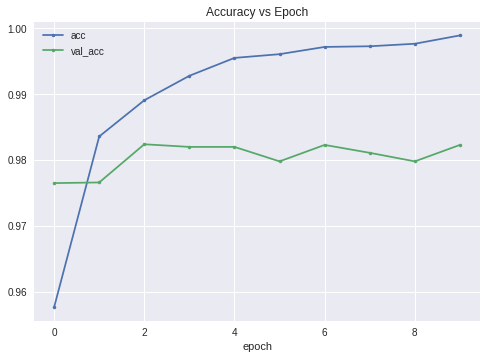

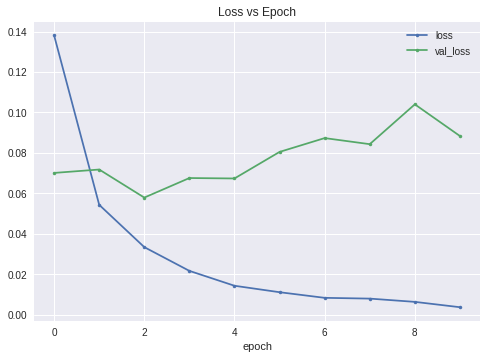

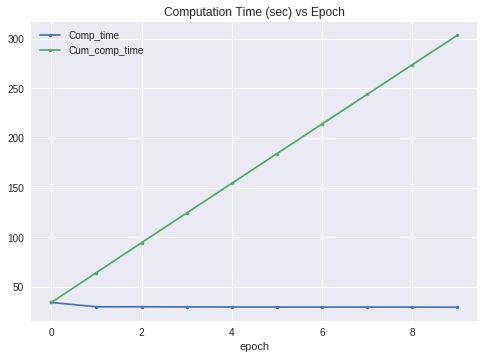

### Model id:  1


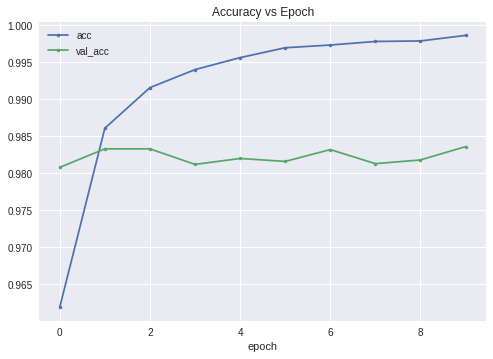

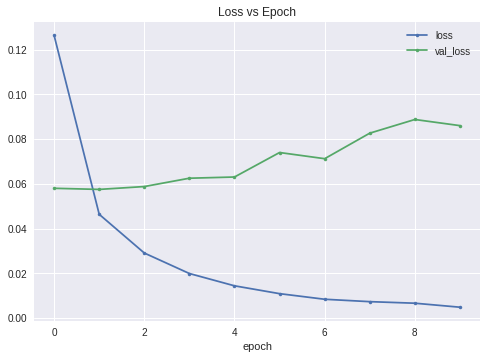

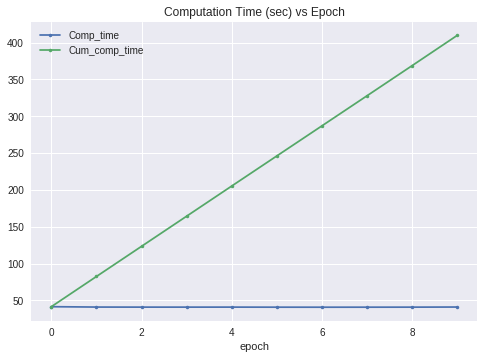

### Model id:  2


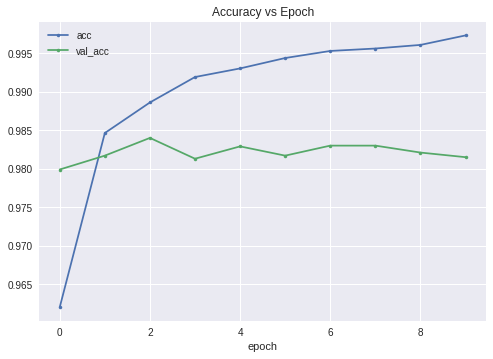

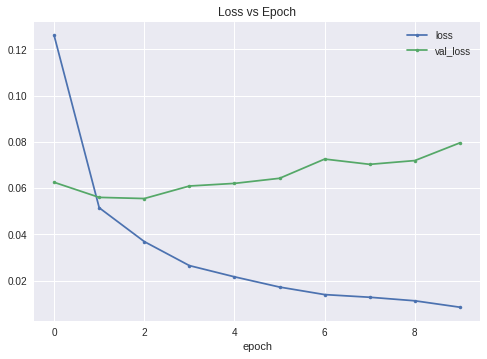

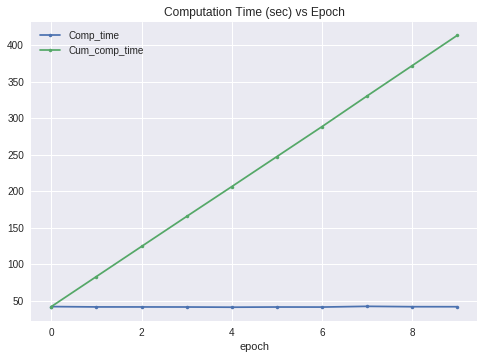

### Model id:  3


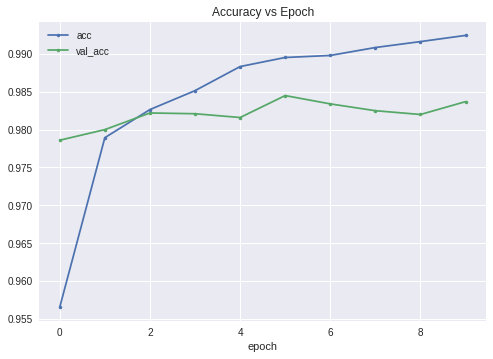

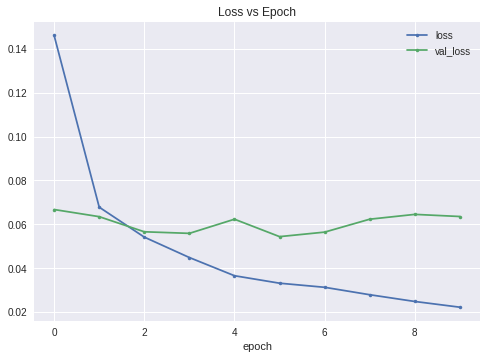

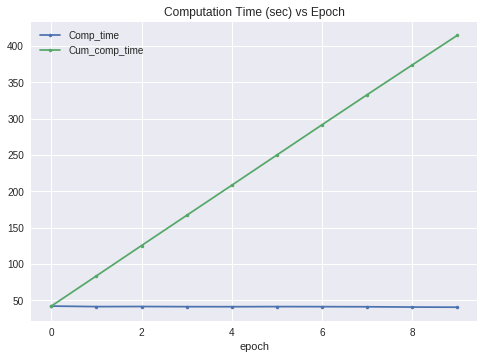

### Model id:  4


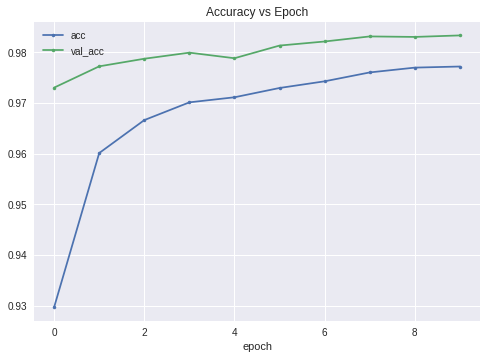

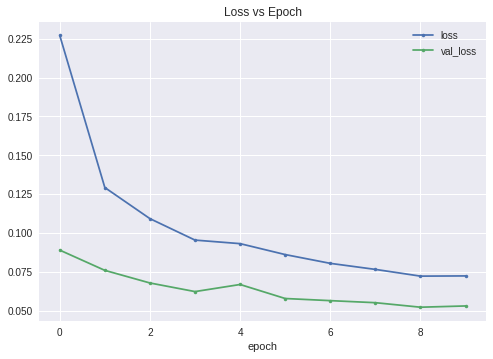

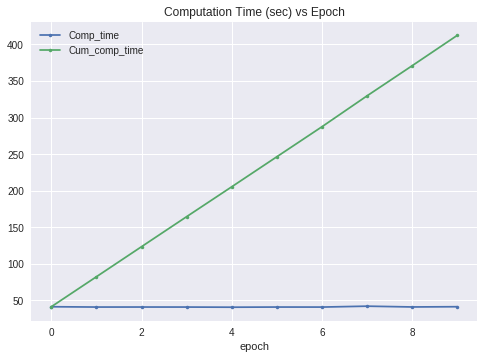

### Model id:  5


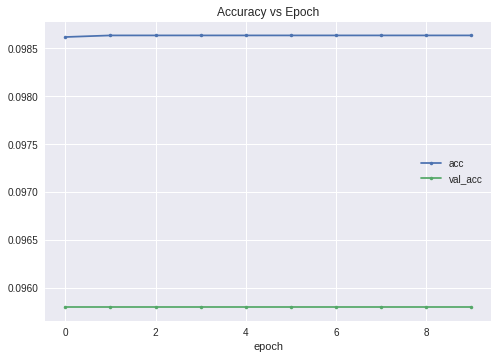

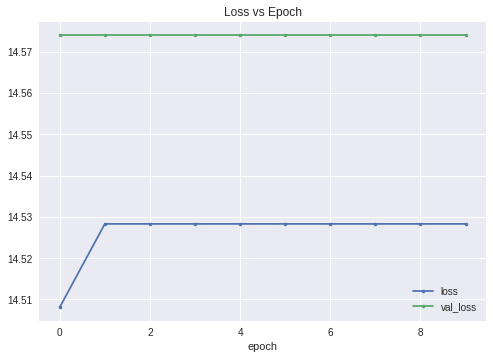

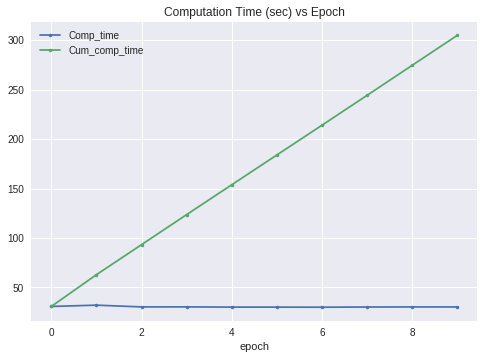

### Model id:  6


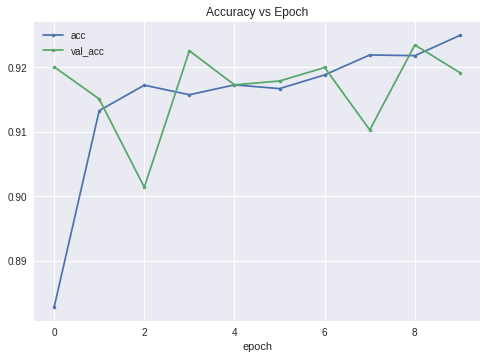

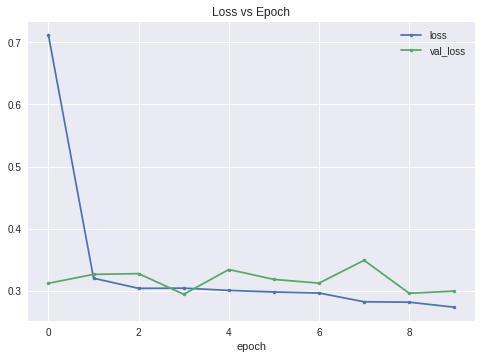

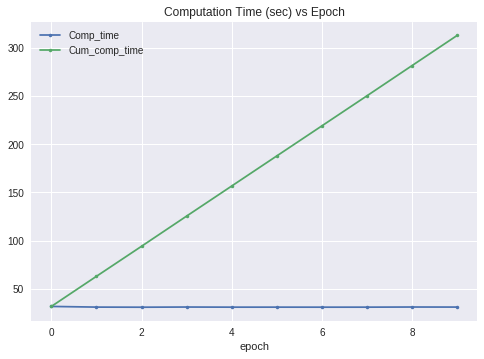

### Model id:  7


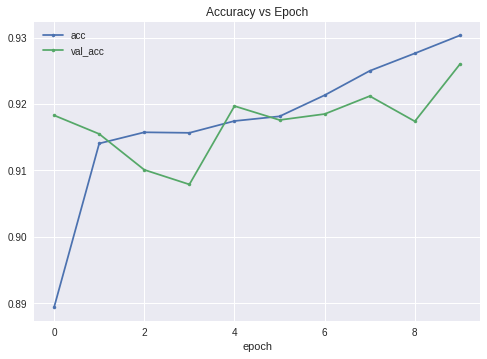

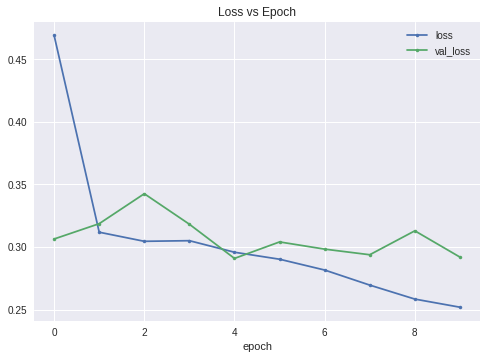

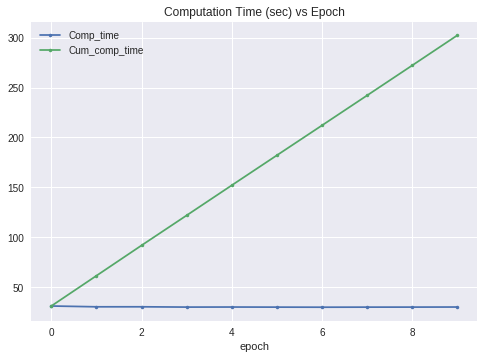

### Model id:  8


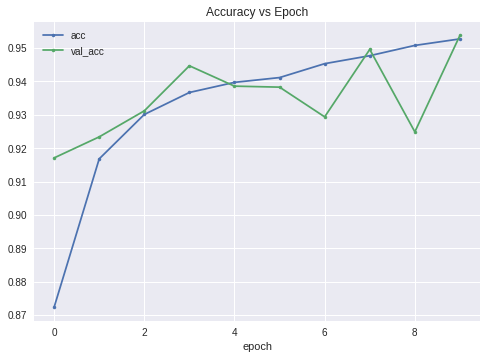

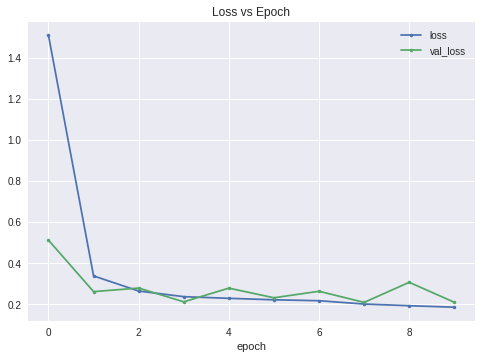

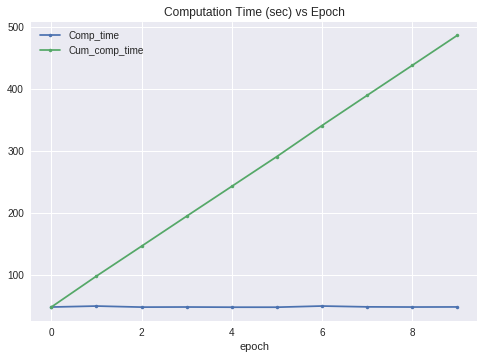

### Model id:  9


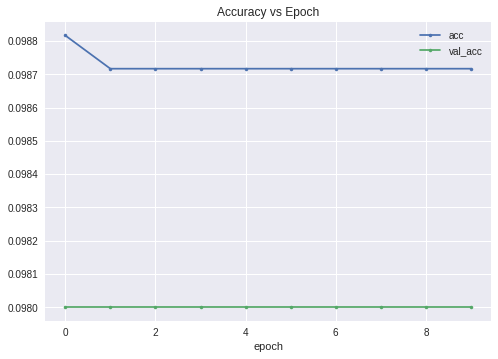

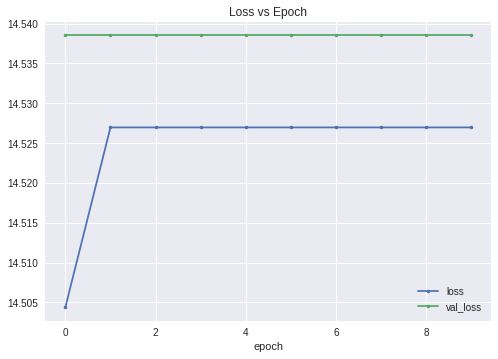

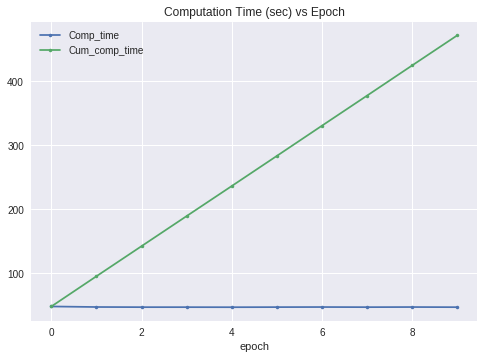

### Model id:  10


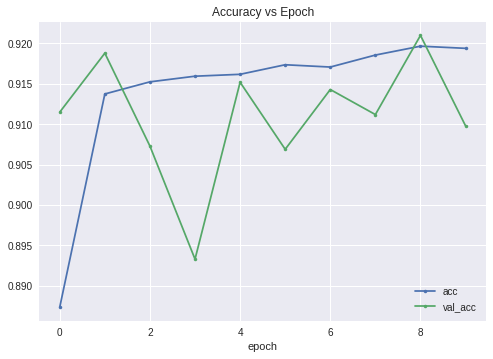

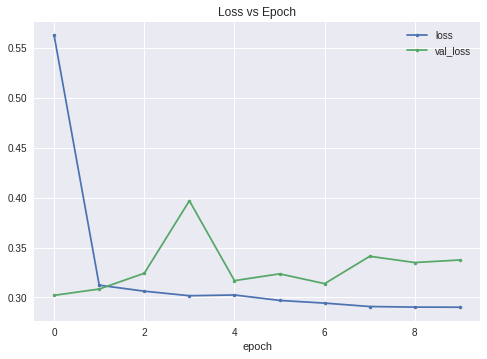

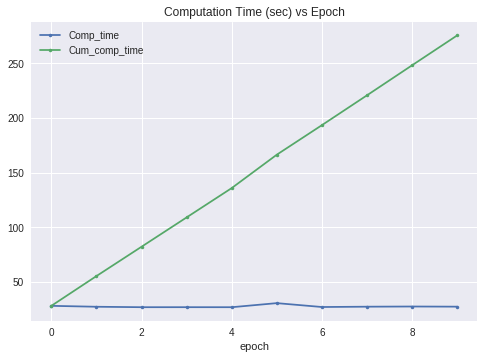

### Model id:  11


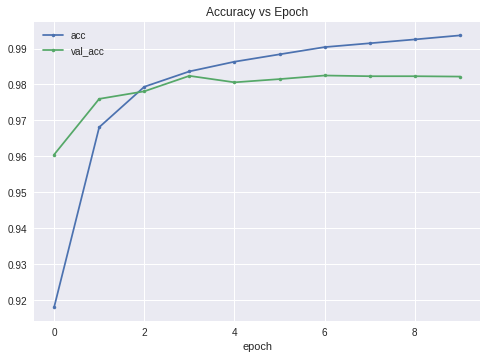

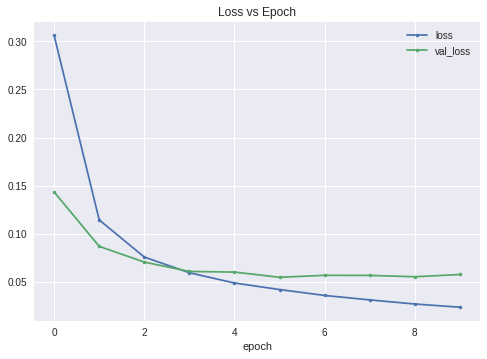

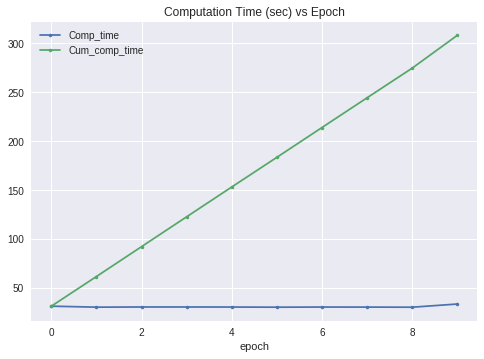

### Model id:  12


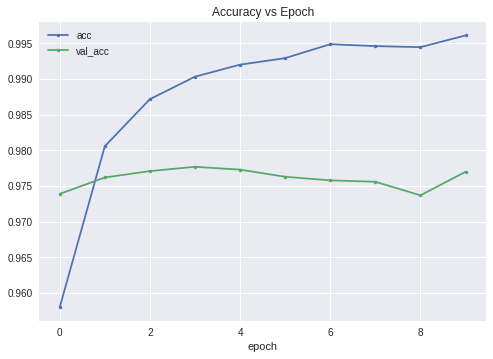

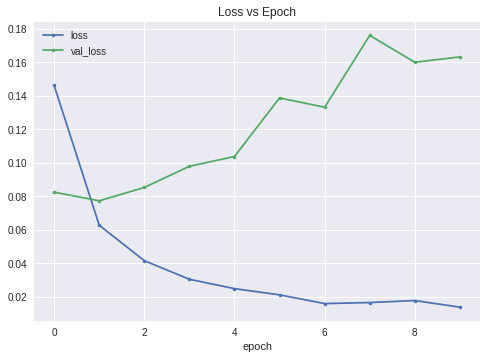

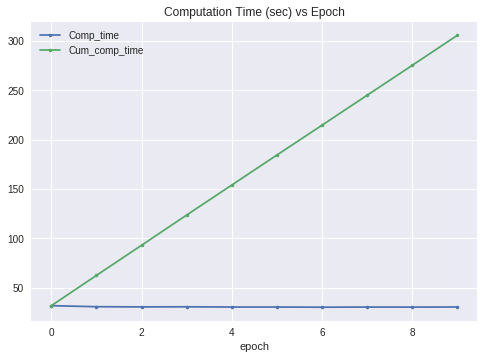

### Model id:  13


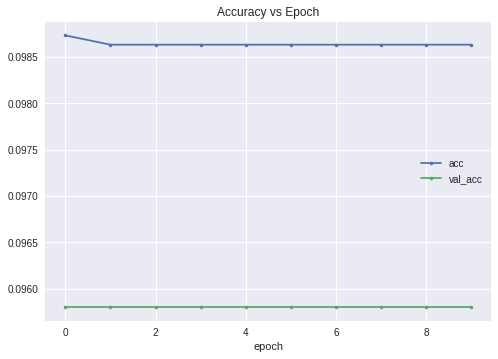

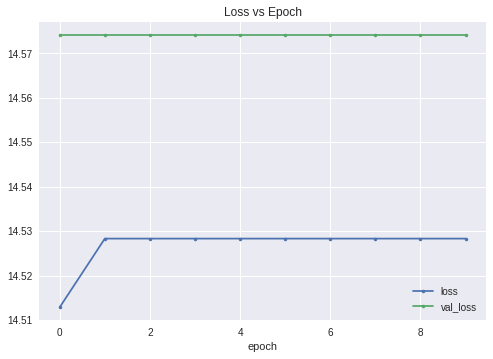

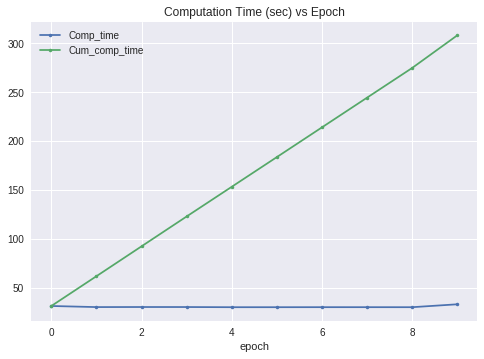

### Model id:  14


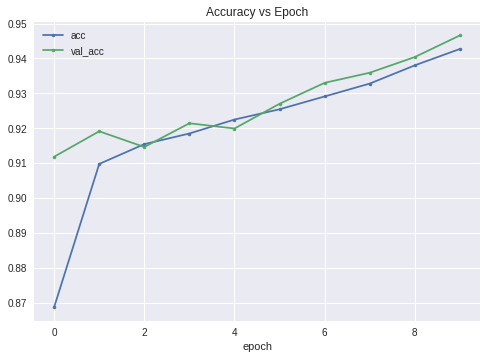

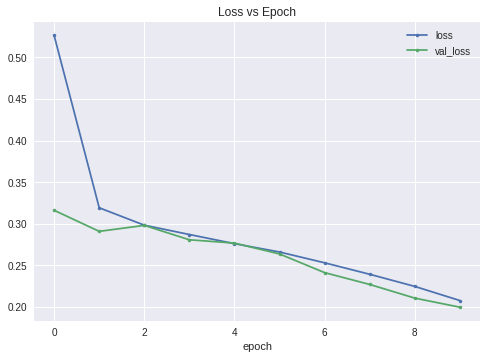

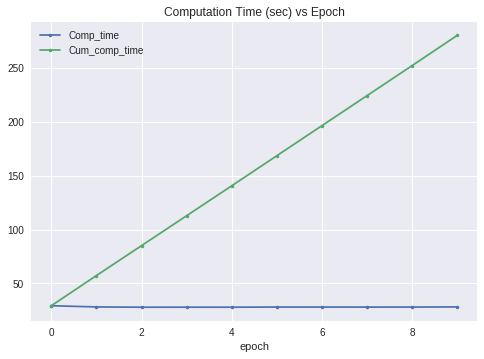

### Model id:  15


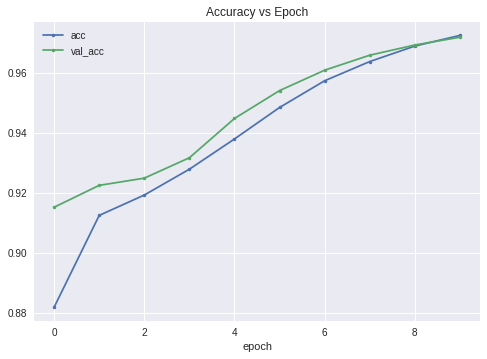

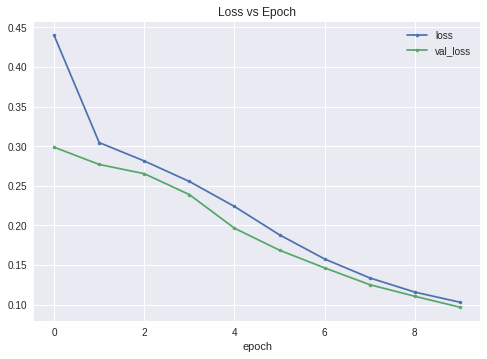

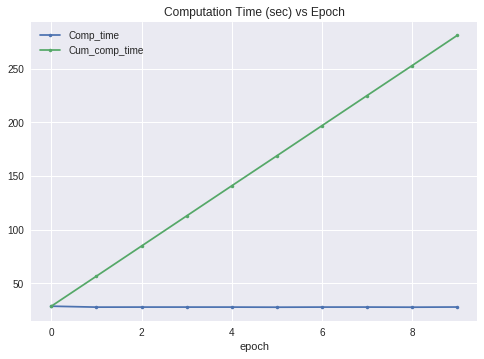

### Model id:  16


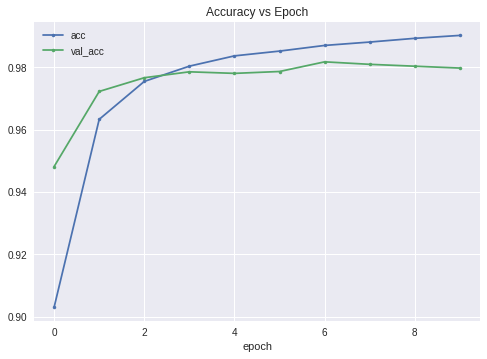

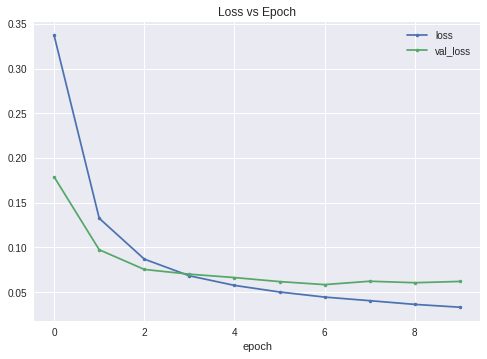

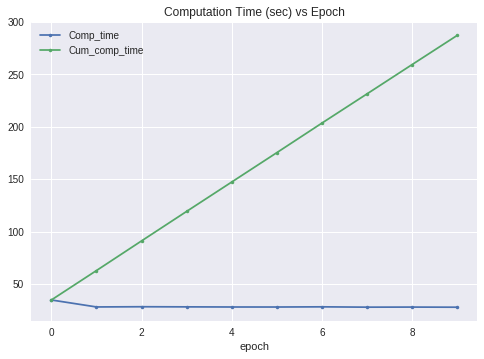

### Model id:  17


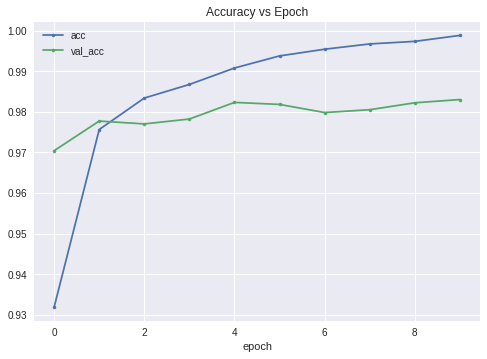

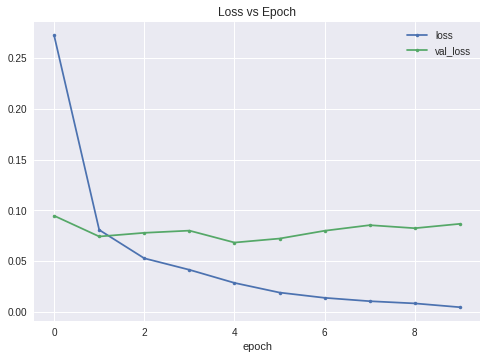

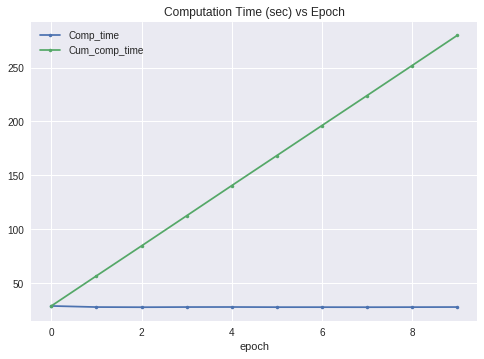

### Model id:  18


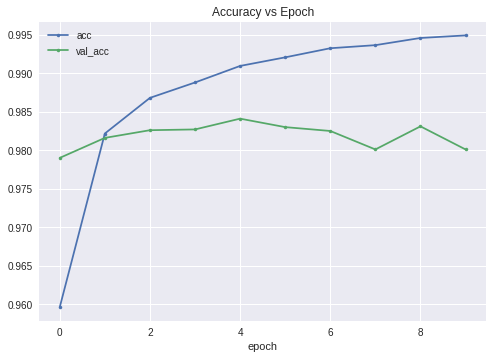

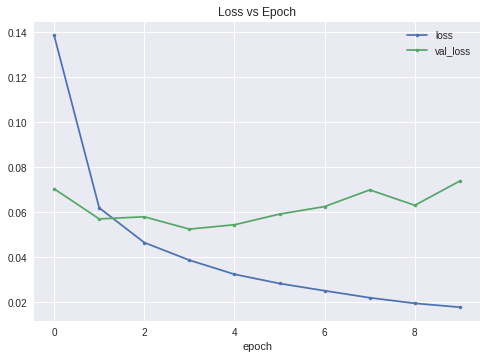

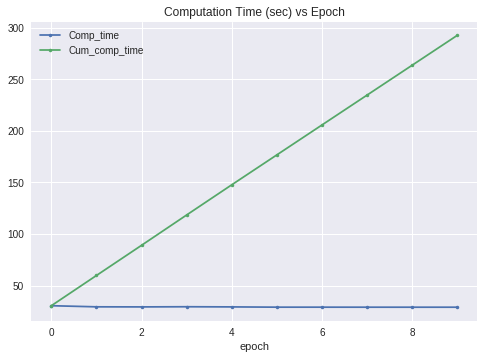

### Model id:  19


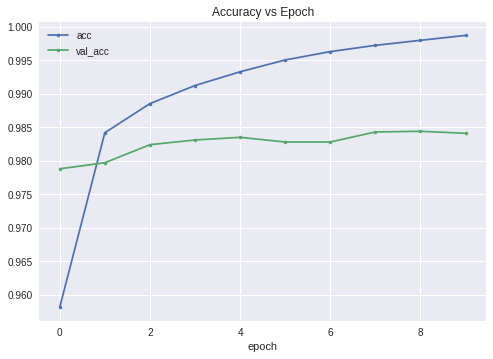

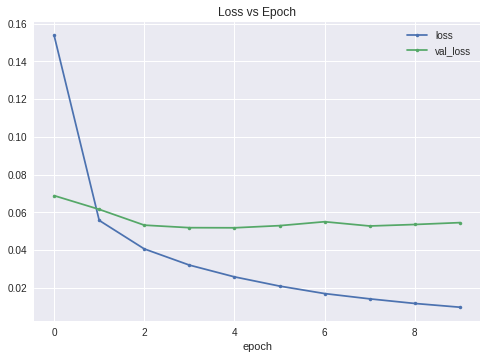

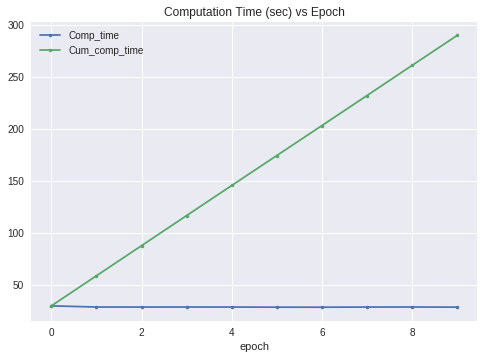

### Model id:  20


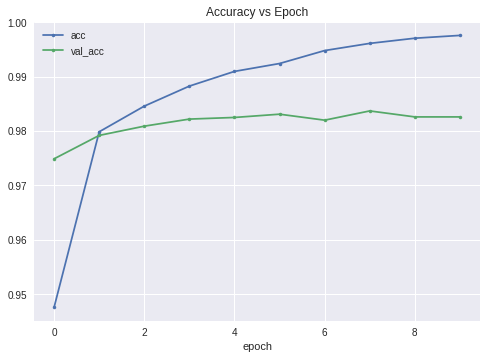

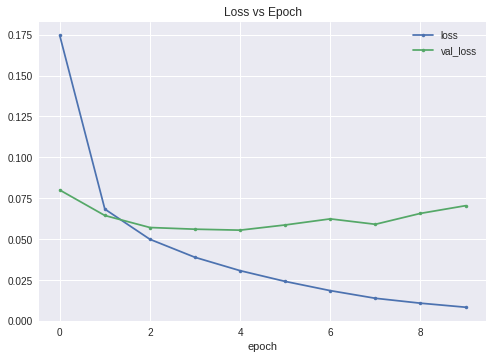

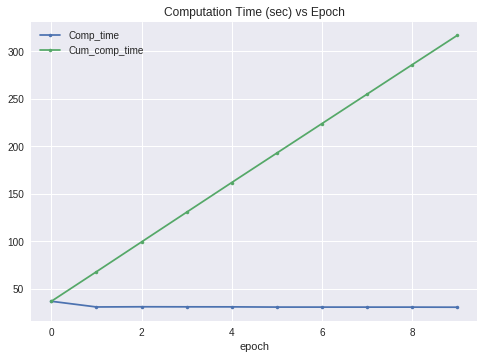

### Model id:  21


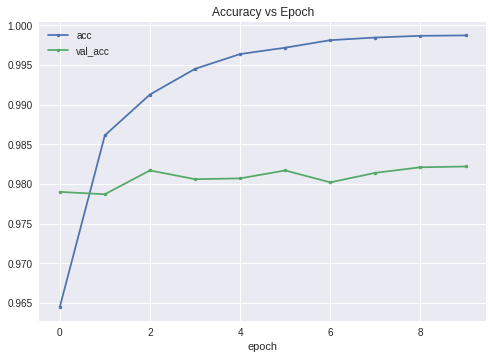

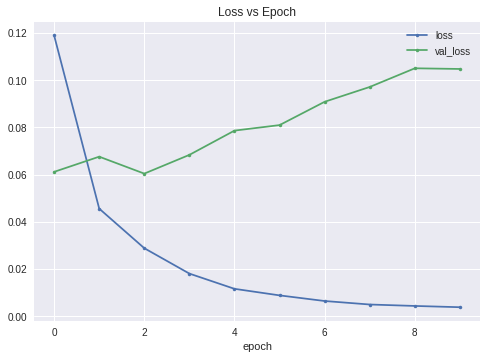

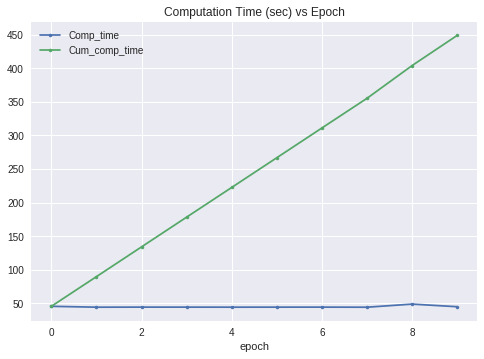

### Model id:  22


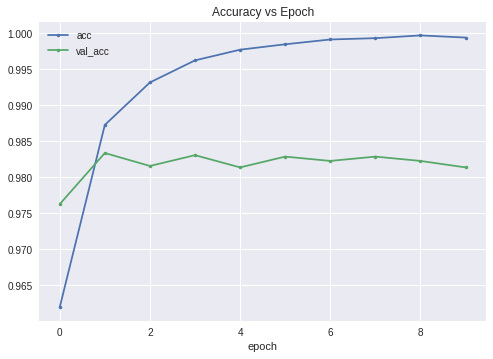

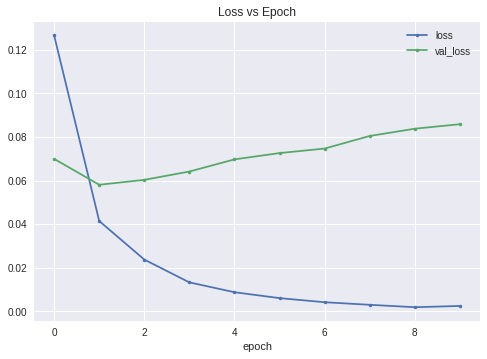

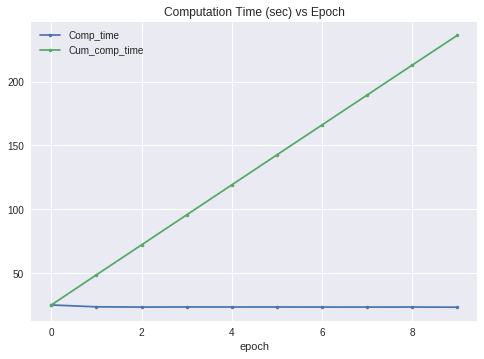

### Model id:  23


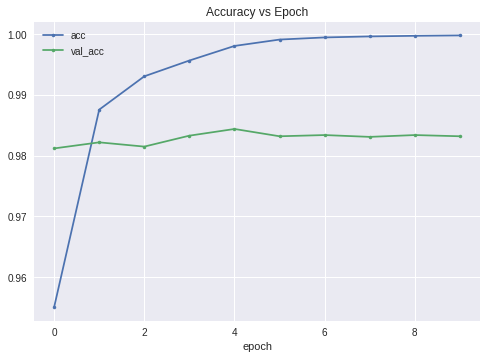

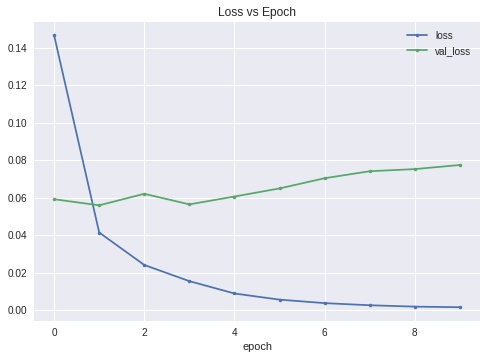

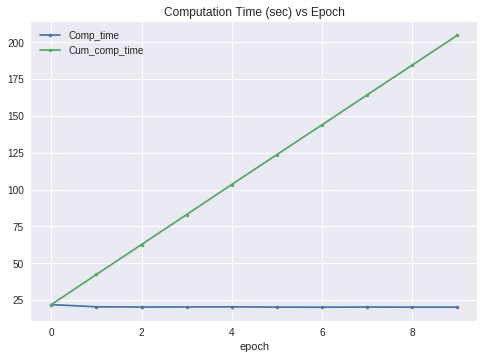

### Model id:  24


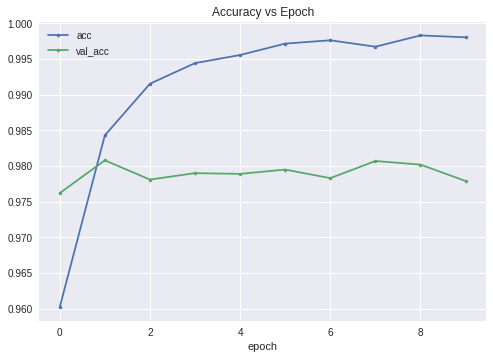

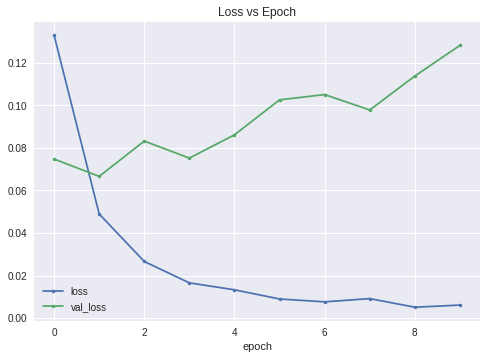

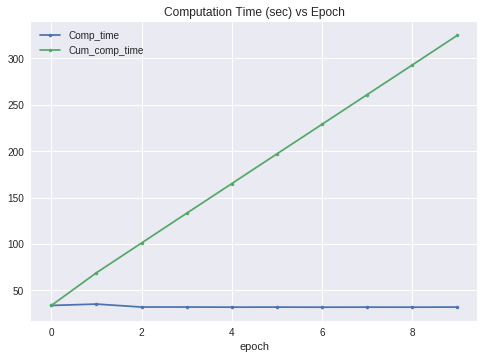

### Model id:  25


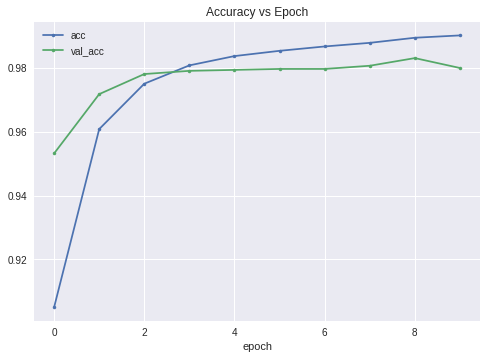

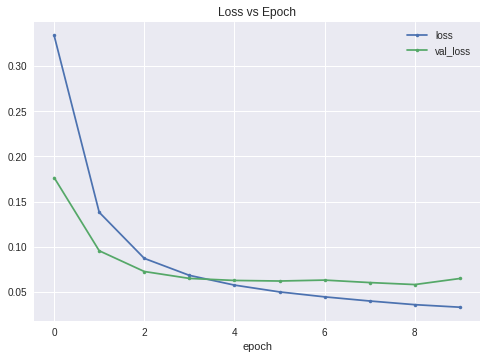

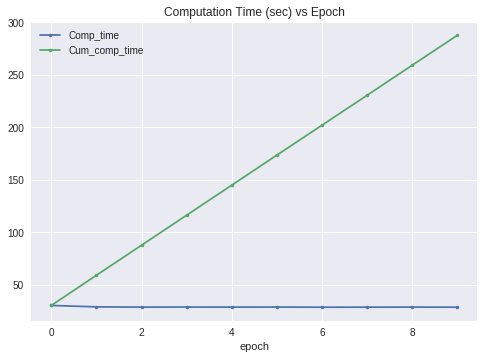

### Model id:  26


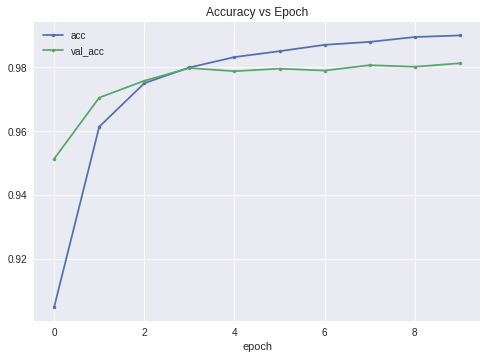

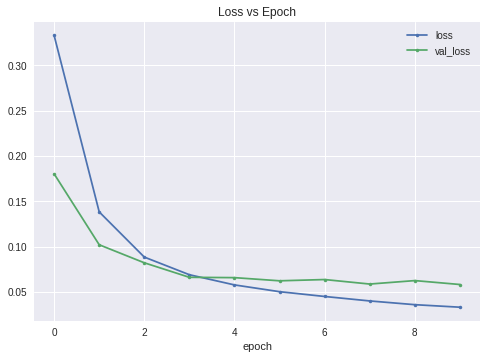

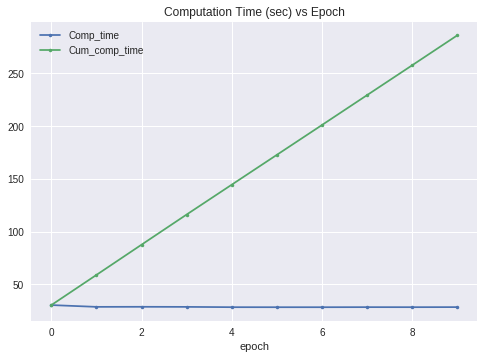

In [8]:
## Plot the results
# pd.options.display.max_rows = 8
lfp.plot_log(show_table=False)


References:


https://keras.io/callbacks/

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

https://keras.io/getting-started/sequential-model-guide/